### 1. Print Circulation Trends 
#### What is the trend in copies printed, copies sold, and net circulation across all cities from 2019 to 2024? How has this changed year-over-year?

In [5]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline
import sklearn


# To show plots inline in the notebook
%matplotlib inline

In [6]:
df_cities = pd.read_csv('../Datasets/Processed Datasets/dim_city.csv')
df_fact_sales = pd.read_csv('../Datasets/Processed Datasets/fact_print_sales.csv')

# Merge on city_id
df = pd.merge(df_fact_sales, df_cities, on='city_id', how='left')

In [7]:
df = df.drop('state_y', axis=1)

In [8]:
df.rename(columns={'state_x': 'state'}, inplace=True)

In [9]:
df['copies_printed'] = df['copies_sold'] + df['copies_returned']

In [10]:
df.head()

,edition_id,city_id,language,state,month,copies_sold,copies_returned,net_circulation,year,city,tier,copies_printed
0,ED1005,C005,Hindi,Rajasthan,May,404389,13510,390879,2023,Jaipur,Tier 2,417899
1,ED1005,C005,Hindi,Rajasthan,March,492943,25024,467919,2019,Jaipur,Tier 2,517967
2,ED1001,C001,Hindi,Uttar Pradesh,July,168893,12285,156608,2023,Lucknow,Tier 2,181178
3,ED1003,C003,Hindi,Madhya Pradesh,July,216540,10117,206423,2023,Bhopal,Tier 2,226657
4,ED1007,C007,Hindi,Jharkhand,October,234563,13048,221515,2020,Ranchi,Tier 3,247611


In [11]:
# Group raw values
yearly_stats = df.groupby('year')[['copies_printed', 'copies_sold', 'net_circulation']].sum().reset_index()

# Overwrite with values in millions
yearly_stats['copies_printed'] = yearly_stats['copies_printed'] / 1_000_000
yearly_stats['copies_sold'] = yearly_stats['copies_sold'] / 1_000_000
yearly_stats['net_circulation'] = yearly_stats['net_circulation'] / 1_000_000

In [12]:
yearly_stats

,year,copies_printed,copies_sold,net_circulation
0,2019,44.109170,41.848668,39.588166
1,2020,41.873081,39.719961,37.566841
2,2021,39.514776,37.501500,35.488224
3,2022,37.267848,35.395333,33.522818
4,2023,35.165397,33.363340,31.561283
5,2024,33.054499,31.325782,29.597065


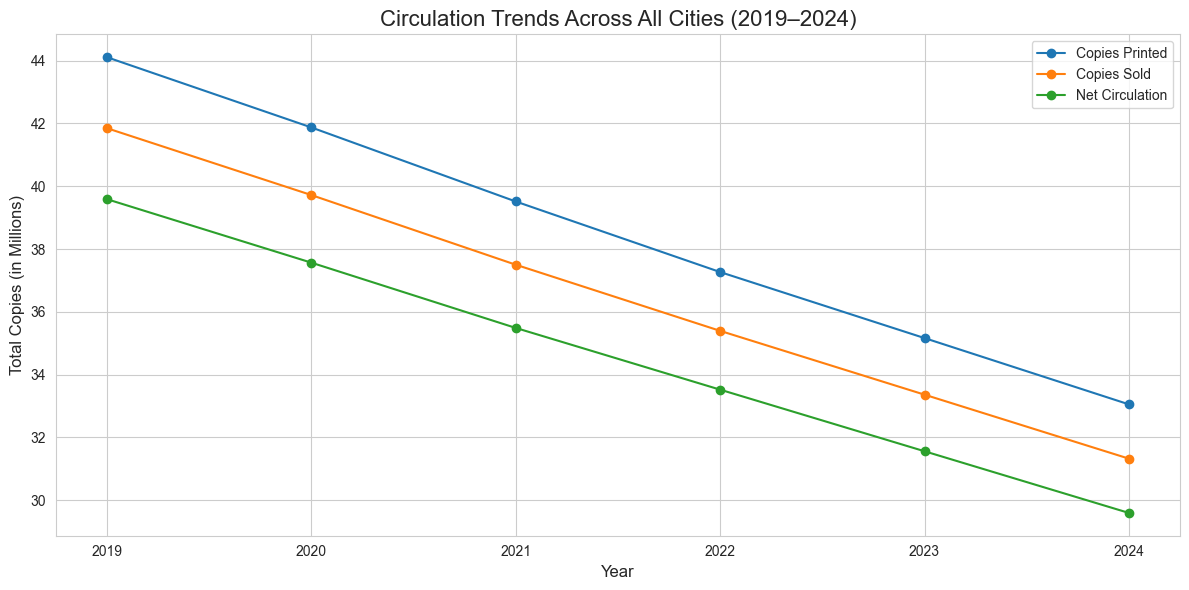

In [13]:
# Use this DataFrame if you're working with scaled values (in millions)
# Rename for clarity (optional)
df_plot = yearly_stats.rename(columns={
    'copies_printed': 'Copies Printed',
    'copies_sold': 'Copies Sold',
    'net_circulation': 'Net Circulation'
})

# Plot settings
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot each metric as a line
plt.plot(df_plot['year'], df_plot['Copies Printed'], marker='o', label='Copies Printed')
plt.plot(df_plot['year'], df_plot['Copies Sold'], marker='o', label='Copies Sold')
plt.plot(df_plot['year'], df_plot['Net Circulation'], marker='o', label='Net Circulation')

# Title and labels
plt.title('Circulation Trends Across All Cities (2019–2024)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Copies (in Millions)', fontsize=12)
plt.xticks(df_plot['year'])  # Ensure proper ticks on X-axis

# Legend
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


### 2. To Performing Cities
#### Which cities contributed the highest to net circulation and copies sold in 2024? Are these cities still profitable to operate in?

In [14]:
df_2024 = df[df['year'] == 2024]

In [15]:
city_stats = df_2024.groupby('city')[['copies_sold', 'net_circulation']].sum().reset_index()

city_stats['copies_sold'] = city_stats['copies_sold'] / 1_000_000
city_stats['net_circulation'] = city_stats['net_circulation'] / 1_000_000

In [16]:
city_stats

,city,copies_sold,net_circulation
0,Ahmedabad,2.896757,2.746691
1,Bhopal,2.565086,2.418567
2,Delhi,3.478045,3.252010
3,Jaipur,4.361397,4.128641
4,Kanpur,3.443849,3.250179
5,Lucknow,1.866824,1.763256
6,Mumbai,3.775800,3.569229
7,Patna,2.379688,2.252819
8,Ranchi,2.200753,2.092062
9,Varanasi,4.357583,4.123611


In [17]:
city_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city             10 non-null     object 
 1   copies_sold      10 non-null     float64
 2   net_circulation  10 non-null     float64
dtypes: float64(2), object(1)
memory usage: 372.0+ bytes


In [18]:
city_stats = city_stats.sort_values(by='net_circulation', ascending=False)

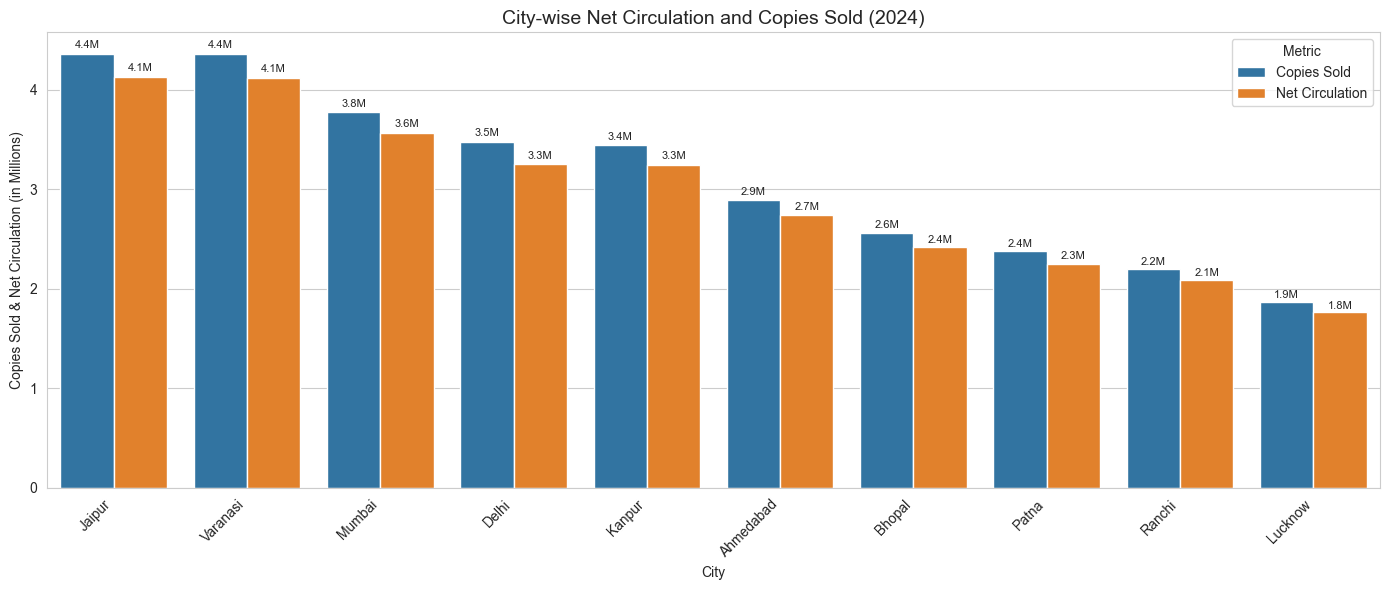

In [19]:
# Assuming 'copies_sold' and 'net_circulation' are already in millions
df_melted = city_stats.melt(id_vars='city', 
                            value_vars=['copies_sold', 'net_circulation'], 
                            var_name='Metric', 
                            value_name='Copies')

df_melted['Metric'] = df_melted['Metric'].replace({
    'copies_sold': 'Copies Sold',
    'net_circulation': 'Net Circulation'
})

plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")
ax = sns.barplot(data=df_melted, x='city', y='Copies', hue='Metric')

# Show labels directly (already in M)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + 0.01 * height,
            f'{height:.1f}M',  # ← display like 4.2M
            ha='center',
            va='bottom',
            fontsize=8
        )

# Final touches
plt.title('City-wise Net Circulation and Copies Sold (2024)', fontsize=14)
plt.xlabel('City')
plt.ylabel('Copies Sold & Net Circulation (in Millions)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


### 3. Print Waste Analysis
#### Which cities have the largest gap between copies printed and net circulation, and how has that gap changed over time?

In [20]:
df['print_waste'] = df['copies_printed'] - df['net_circulation']

In [21]:
df.head()

,edition_id,city_id,language,state,month,copies_sold,copies_returned,net_circulation,year,city,tier,copies_printed,print_waste
0,ED1005,C005,Hindi,Rajasthan,May,404389,13510,390879,2023,Jaipur,Tier 2,417899,27020
1,ED1005,C005,Hindi,Rajasthan,March,492943,25024,467919,2019,Jaipur,Tier 2,517967,50048
2,ED1001,C001,Hindi,Uttar Pradesh,July,168893,12285,156608,2023,Lucknow,Tier 2,181178,24570
3,ED1003,C003,Hindi,Madhya Pradesh,July,216540,10117,206423,2023,Bhopal,Tier 2,226657,20234
4,ED1007,C007,Hindi,Jharkhand,October,234563,13048,221515,2020,Ranchi,Tier 3,247611,26096


In [22]:
waste_by_city = df.groupby('city')['print_waste'].sum().reset_index()

waste_by_city['print_waste'] = waste_by_city['print_waste'] / 1_000_000

waste_by_city = waste_by_city.sort_values(by='print_waste', ascending=False)

In [23]:
waste_by_city

,city,print_waste
9,Varanasi,3.353578
3,Jaipur,3.177964
6,Mumbai,2.812846
2,Delhi,2.738782
4,Kanpur,2.523300
0,Ahmedabad,2.288644
1,Bhopal,1.918452
7,Patna,1.824164
8,Ranchi,1.605262
5,Lucknow,1.417382


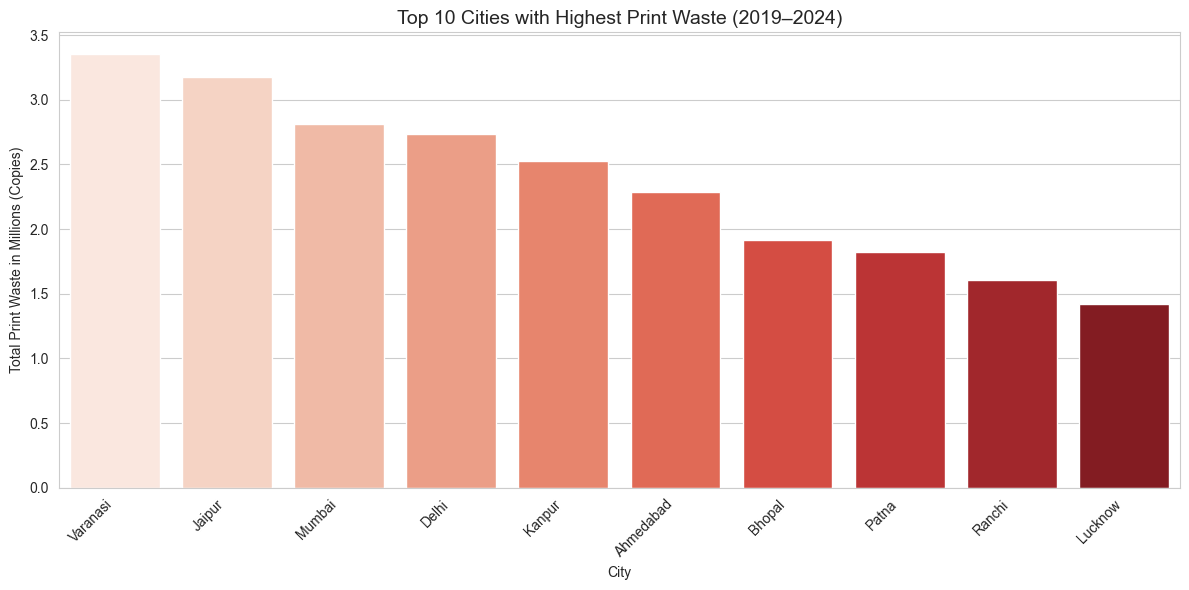

In [24]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.barplot(
    data=waste_by_city.head(10),
    x='city',
    y='print_waste',
    hue='city',
    palette='Reds',
    legend=False
)

plt.title('Top 10 Cities with Highest Print Waste (2019–2024)', fontsize=14)
plt.xlabel('City')
plt.ylabel('Total Print Waste in Millions (Copies)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 4. Ad Revenue Trends by Category
#### How has ad revenue evolved across different ad categories between 2019 and 2024? Which categories have remained strong, and which have declined?

In [25]:
df_ad_revenue = pd.read_csv('../Datasets/Processed Datasets/fact_ad_revenue.csv')

In [26]:
print(df_ad_revenue.columns)

Index(['edition_id', 'ad_category', 'quarter', 'ad_revenue', 'currency',
       'comments', 'USD_to_INR', 'EUR_to_INR', 'revenue_in_INR', 'year'],
      dtype='object')


In [27]:
ad_trend = df_ad_revenue.groupby(['year','ad_category'])['revenue_in_INR'].sum().reset_index()

ad_trend['revenue_in_INR'] = ad_trend['revenue_in_INR'] / 1_000_000  # now in millions

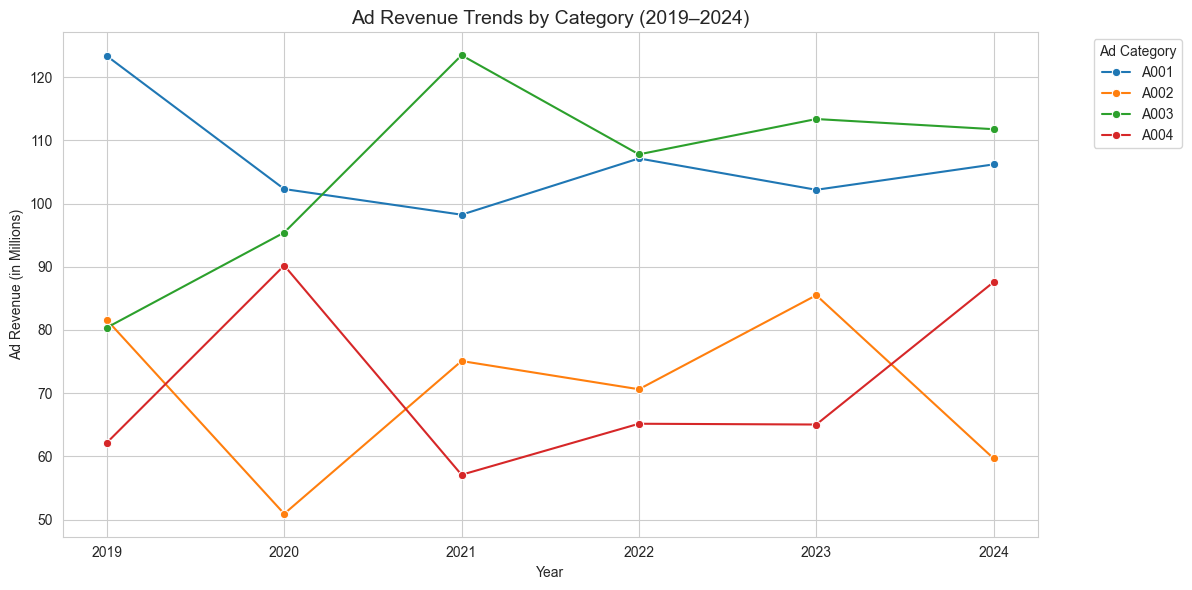

In [28]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Lineplot: each category will have a line
sns.lineplot(data=ad_trend, x='year', y='revenue_in_INR', hue='ad_category', marker='o')

# Labels and formatting
plt.title('Ad Revenue Trends by Category (2019–2024)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Ad Revenue (in Millions)')
plt.legend(title='Ad Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 5. City-Level Ad Revenue Performance
#### Which cities generated the most ad revenue, and how does that correlate with their print circulation?

In [29]:
df_cities = pd.read_csv('../Datasets/Processed Datasets/dim_city.csv')
df_ad_revenue = pd.read_csv('../Datasets/Processed Datasets/fact_ad_revenue.csv')
df_print_sales = pd.read_csv('../Datasets/Processed Datasets/fact_print_sales.csv')

# Merge on edition_id to get city_id into ad revenue
df_ad_city = df_ad_revenue.merge(df_print_sales[['edition_id', 'city_id']], on='edition_id', how='left')
# Merge with df_cities to get city names
df_ad_city = df_ad_city.merge(df_cities[['city_id', 'city']], on='city_id', how='left')

In [30]:
df_ad_city.head(1)

,edition_id,ad_category,quarter,ad_revenue,currency,comments,USD_to_INR,EUR_to_INR,revenue_in_INR,year,city_id,city
0,ED1005,A001,2023-Q2,22613.69,EUR,NaN,78.5,88.5,2001311.56,2023,C005,Jaipur


In [31]:
ad_by_city = df_ad_city.groupby('city')['revenue_in_INR'].sum().reset_index()
ad_by_city['revenue_in_INR'] = ad_by_city['revenue_in_INR'] / 1_000_000_000  # in billions

In [32]:
ad_by_city.head()

,city,revenue_in_INR
0,Ahmedabad,15.362686
1,Bhopal,16.285053
2,Delhi,15.161847
3,Jaipur,15.406804
4,Kanpur,14.067191


In [33]:
circulation_by_city = df_print_sales.groupby('city_id')['net_circulation'].sum().reset_index()
circulation_by_city = circulation_by_city.merge(df_cities[['city_id', 'city']], on='city_id', how='left')

In [34]:
circulation_by_city.head(1)

,city_id,net_circulation,city
0,C001,12333385,Lucknow


In [35]:
city_level_df = ad_by_city.merge(circulation_by_city[['city', 'net_circulation']], on='city', how='inner')

In [36]:
city_level_df['net_circulation'] = city_level_df['net_circulation'] / 1_000_000

In [37]:
city_level_df

,city,revenue_in_INR,net_circulation
0,Ahmedabad,15.362686,19.155753
1,Bhopal,16.285053,16.969882
2,Delhi,15.161847,22.821731
3,Jaipur,15.406804,29.032754
4,Kanpur,14.067191,22.759261
5,Lucknow,15.512412,12.333385
6,Mumbai,15.604017,24.961046
7,Patna,16.589718,15.753919
8,Ranchi,14.904585,14.740028
9,Varanasi,13.903602,28.796638


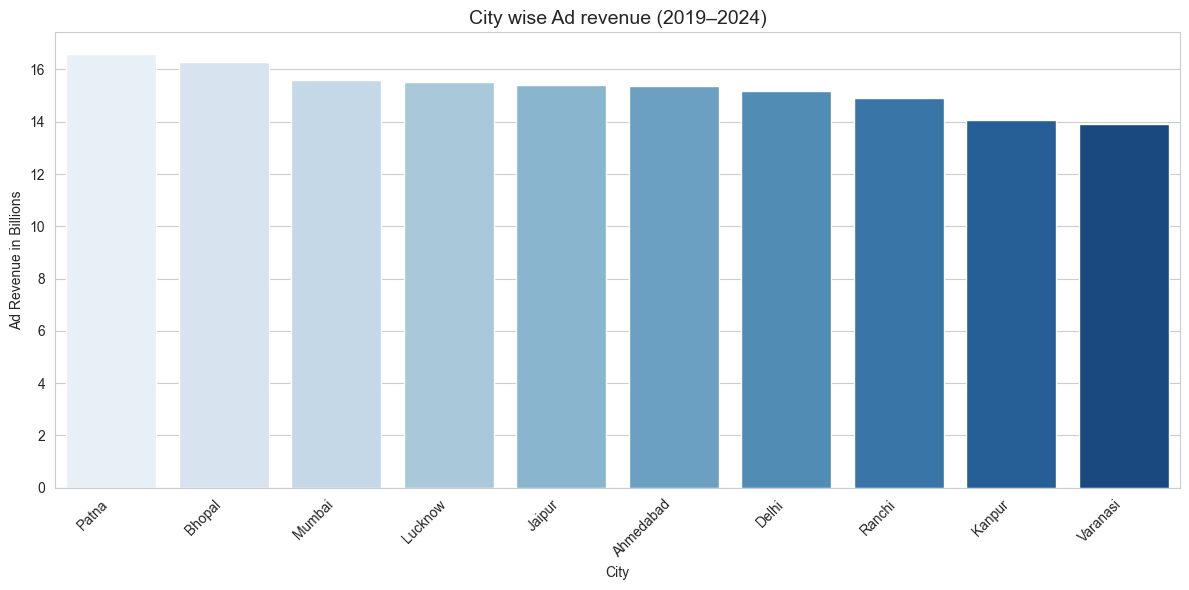

In [38]:
city_level_df = city_level_df.sort_values(by='revenue_in_INR', ascending=False)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.barplot(
    data=city_level_df,
    x='city',
    y='revenue_in_INR',
    hue='city',
    palette='Blues',
    legend=False
)

plt.title('City wise Ad revenue (2019–2024)', fontsize=14)
plt.xlabel('City')
plt.ylabel('Ad Revenue in Billions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

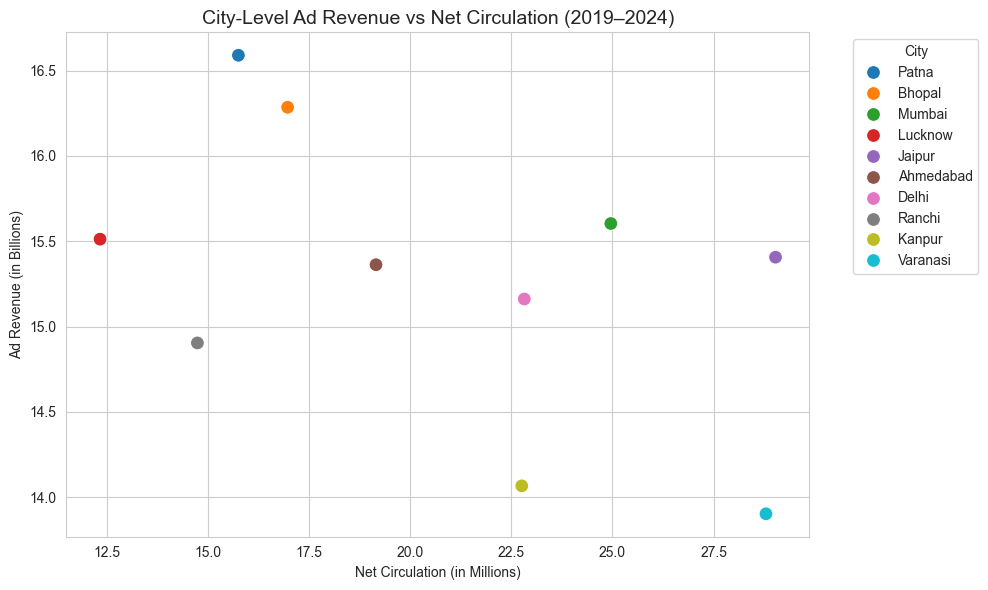

In [39]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.scatterplot(
    data=city_level_df,
    x='net_circulation',
    y='revenue_in_INR',
    hue='city',
    s=100
)

plt.title('City-Level Ad Revenue vs Net Circulation (2019–2024)', fontsize=14)
plt.xlabel('Net Circulation (in Millions)')
plt.ylabel('Ad Revenue (in Billions)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='City')
plt.tight_layout()
plt.show()


### 6. Digital Readiness vs. Performance
#### Which cities show high digital readiness (based on smartphone, internet, and literacy rates) but had low digital pilot engagement?

In [40]:
df_cities = pd.read_csv('../Datasets/Processed Datasets/dim_city.csv')
df_city_readiness = pd.read_csv('../Datasets/Processed Datasets/fact_city_readiness.csv')
df_digital_rate = pd.read_csv('../Datasets/Processed Datasets/fact_digital_pilot.csv')

In [68]:
df_digital_rate.columns

Index(['platform', 'launch_month', 'ad_category_id', 'dev_cost',
       'marketing_cost', 'users_reached', 'downloads_or_accesses',
       'avg_bounce_rate', 'cumulative_feedback_from_customers', 'city_id',
       'year', 'month_name'],
      dtype='object')

In [41]:
df_readiness = df_city_readiness.groupby('city_id')[['literacy_rate', 'smartphone_penetration', 'internet_penetration']].mean().reset_index()

df_readiness['readiness_score'] = (
    df_readiness['literacy_rate'] +
    df_readiness['smartphone_penetration'] +
    df_readiness['internet_penetration']
) / 3

In [42]:
# Group by city and sum metrics
df_performance = df_digital_rate.groupby('city_id')[['downloads_or_accesses', 'users_reached']].sum().reset_index()

# Calculate engagement rate per city
df_performance['digital_pilot_engagement'] = (
    df_performance['downloads_or_accesses'] / df_performance['users_reached']
) * 100  # percentage


In [43]:
df_combined = df_readiness.merge(df_performance, on='city_id', how='left')
df_combined = df_combined.merge(df_cities, on='city_id', how='left')

In [44]:
df_final = df_combined[[
    'city_id',
    'city',
    'state',
    'tier',
    'readiness_score',
    'digital_pilot_engagement'
]]

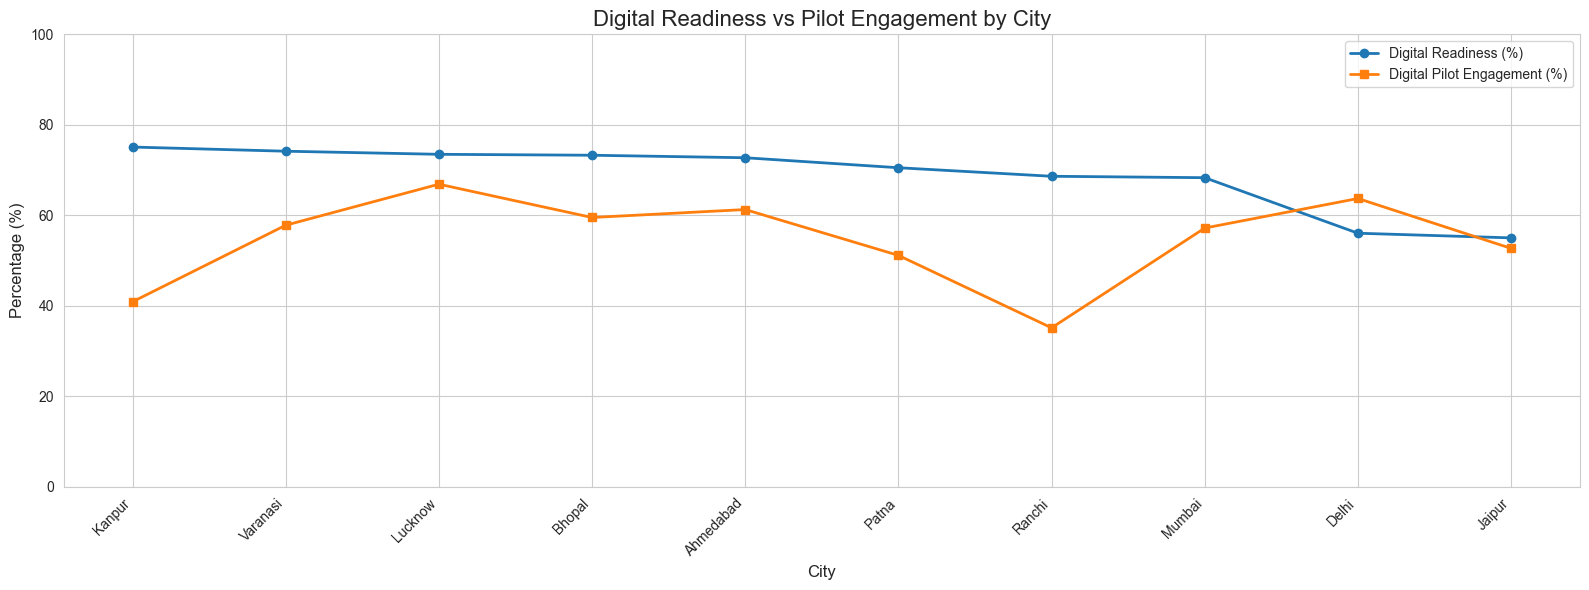

In [45]:
plt.figure(figsize=(16, 6))
sns.set_style("whitegrid")

# Sort cities by readiness score for a cleaner x-axis
df_final_sorted = df_final.sort_values('readiness_score', ascending=False)

# Plot digital readiness
plt.plot(
    df_final_sorted['city'],
    df_final_sorted['readiness_score'],
    marker='o',
    label='Digital Readiness (%)',
    linewidth=2
)

# Plot digital engagement
plt.plot(
    df_final_sorted['city'],
    df_final_sorted['digital_pilot_engagement'],
    marker='s',
    label='Digital Pilot Engagement (%)',
    linewidth=2
)

# Labels and title
plt.title('Digital Readiness vs Pilot Engagement by City', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()


In [67]:
df_final

,city_id,city,state,tier,readiness_score,digital_pilot_engagement
0,C001,Lucknow,Uttar Pradesh,Tier 2,73.494444,66.886926
1,C002,Delhi,Delhi,Tier 1,56.047083,63.725983
2,C003,Bhopal,Madhya Pradesh,Tier 2,73.287778,59.524014
3,C004,Patna,Bihar,Tier 2,70.526806,51.150245
4,C005,Jaipur,Rajasthan,Tier 2,55.016528,52.695917
5,C006,Mumbai,Maharashtra,Tier 1,68.325000,57.186083
6,C007,Ranchi,Jharkhand,Tier 3,68.638750,35.129171
7,C008,Kanpur,Uttar Pradesh,Tier 2,75.098750,40.889475
8,C009,Ahmedabad,Gujarat,Tier 1,72.735000,61.280860
9,C010,Varanasi,Uttar Pradesh,Tier 2,74.178750,57.815174


### 7. Ad Revenue vs. Circulation ROI
#### Which cities had the highest ad revenue per net circulated copy? Is this ratio improving or worsening over time?

In [47]:
df_cities = pd.read_csv('../Datasets/Processed Datasets/dim_city.csv')
df_ad_revenue = pd.read_csv('../Datasets/Processed Datasets/fact_ad_revenue.csv')
df_print_sales = pd.read_csv('../Datasets/Processed Datasets/fact_print_sales.csv')

# Merge on edition_id to get city_id into ad revenue
df_city_comparison = df_ad_revenue.merge(df_print_sales[['edition_id', 'city_id','net_circulation','year']], on=['edition_id', 'year'], how='left')
# Merge with df_cities to get city names
df_city_comparison = df_city_comparison.merge(df_cities[['city_id', 'city']], on='city_id', how='left')

In [48]:
revenue_by_city_year = df_city_comparison.groupby(['city', 'year'])['revenue_in_INR'].sum().reset_index()
revenue_by_city_year['revenue_in_INR'] = revenue_by_city_year['revenue_in_INR'] / 1_000_000

In [49]:
circulation_by_city_year = df_city_comparison.groupby(['city', 'year'])['net_circulation'].sum().reset_index()
circulation_by_city_year['net_circulation'] = circulation_by_city_year['net_circulation'] / 1_000_000

In [50]:
city_level_df = revenue_by_city_year.merge(circulation_by_city_year, on=['city','year'])

# Ad revenue per copy in millions
city_level_df['ad_revenue_per_copy'] = (city_level_df['revenue_in_INR'] / city_level_df['net_circulation']) 
city_level_df['ad_revenue_per_copy'] = city_level_df['ad_revenue_per_copy'].round(3)

In [51]:
city_level_df.head()

,city,year,revenue_in_INR,net_circulation,ad_revenue_per_copy
0,Ahmedabad,2019,429.746924,43.494492,9.880
1,Ahmedabad,2020,444.380980,41.461608,10.718
2,Ahmedabad,2021,377.695046,39.770340,9.497
3,Ahmedabad,2022,515.421065,37.318668,13.811
4,Ahmedabad,2023,371.176455,34.863636,10.647


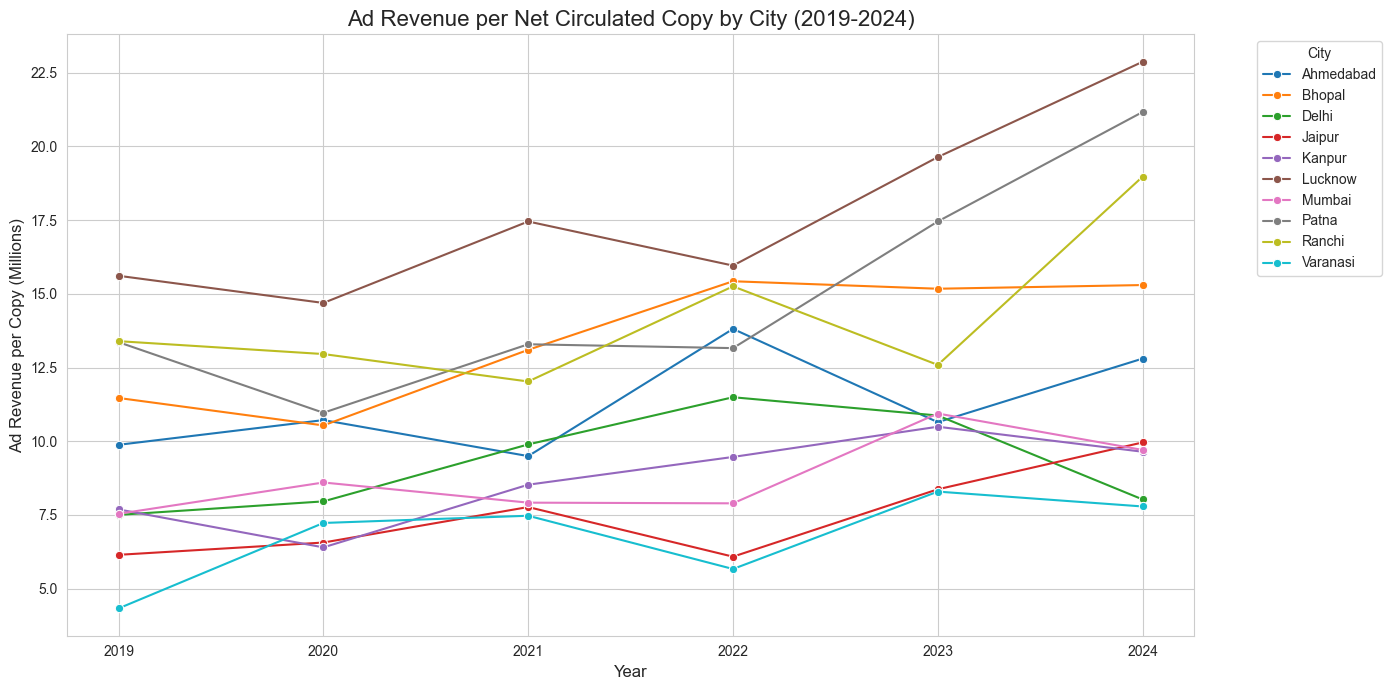

In [52]:
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# Lineplot
sns.lineplot(
    data=city_level_df,
    x='year',
    y='ad_revenue_per_copy',
    hue='city',
    marker='o',
    palette='tab10'
)

plt.title('Ad Revenue per Net Circulated Copy by City (2019-2024)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Ad Revenue per Copy (Millions)', fontsize=12)  # updated label
plt.xticks(city_level_df['year'].unique())
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 8. Digital Relaunch City Prioritization
#### Based on digital readiness, pilot engagement, and print decline, which 3 cities should be prioritized for Phase 1 of the digital relaunch?

In [53]:
circulation_by_city_year = df_print_sales.groupby(['city_id','year'])['net_circulation'].sum().reset_index()

# Merge with city names
circulation_by_city_year = circulation_by_city_year.merge(
    df_cities[['city_id','city']],
    on='city_id',
    how='left'
)

# Convert to millions
circulation_by_city_year['net_circulation'] = circulation_by_city_year['net_circulation'] / 1_000_000


In [65]:
df_print_decline = circulation_by_city_year.groupby('city').agg(
    net_circulation_start=('net_circulation', lambda x: x.iloc[0]),
    net_circulation_end=('net_circulation', lambda x: x.iloc[-1])
).reset_index()

df_print_decline['print_decline_pct'] = 100 * (
    df_print_decline['net_circulation_start'] - df_print_decline['net_circulation_end']
) / df_print_decline['net_circulation_start']


In [55]:
df_phase1 = df_final.merge(
    df_print_decline[['city','print_decline_pct']],
    on='city',
    how='left'
)

In [57]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_phase1[['readiness_norm', 'pilot_engagement_norm', 'print_decline_norm']] = scaler.fit_transform(
    df_phase1[['readiness_score', 'digital_pilot_engagement', 'print_decline_pct']]
)

In [58]:
df_phase1['priority_score'] = (
    0.4 * df_phase1['readiness_norm'] +
    0.3 * df_phase1['pilot_engagement_norm'] +
    0.3 * df_phase1['print_decline_norm']
)

In [59]:
df_phase1 = df_phase1.sort_values('priority_score', ascending=False).reset_index(drop=True)
top3_cities = df_phase1.head(3)['city'].tolist()
top3_cities

['Bhopal', 'Varanasi', 'Lucknow']

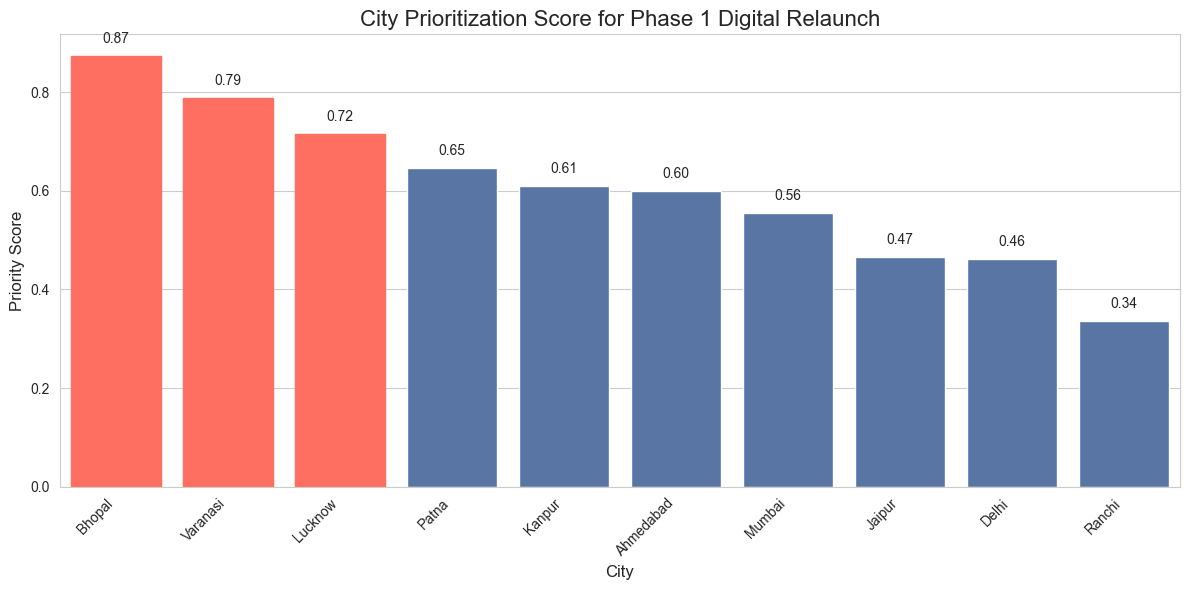

In [60]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

ax = sns.barplot(
    data=df_phase1,
    x='city',
    y='priority_score',
    color='#4C72B0'
)

# Highlight top 3 cities
for i, p in enumerate(ax.patches):
    city_name = df_phase1.iloc[i]['city']
    height = p.get_height()
    if city_name in top3_cities:
        p.set_color('#FF6F61')  # Highlight top 3
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 0.02,
        f'{height:.2f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('City Prioritization Score for Phase 1 Digital Relaunch', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Priority Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
